In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.linalg import block_diag
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from src.FirstRoundTest import Forecast

In [98]:
csv_file_path = "./tutorial.csv"
df = pd.read_csv(csv_file_path, sep=';')

products = np.unique(df['product'])
print(products)

raw = {}

for product in products:
    raw[product] = df[df['product'] == product]

['AMETHYSTS' 'STARFRUIT']


In [99]:
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor

# Prepare the data
data_series = raw[products[1]]['mid_price']
raw[products[1]] = raw[products[1]].fillna(0)

weighted_data_series = ((raw[products[1]]['ask_price_1'] * raw[products[1]]['ask_volume_1'] 
                        + raw[products[1]]['bid_price_1'] * raw[products[1]]['bid_volume_1']
                        + raw[products[1]]['ask_price_2'] * raw[products[1]]['ask_volume_2']
                        + raw[products[1]]['bid_price_2'] * raw[products[1]]['bid_volume_2']
                        + raw[products[1]]['ask_price_3'] * raw[products[1]]['ask_volume_3']
                        + raw[products[1]]['bid_price_3'] * raw[products[1]]['bid_volume_3']
                         ) 
                        / (
                        raw[products[1]]['ask_volume_1'] + raw[products[1]]['bid_volume_1']
                        + raw[products[1]]['ask_volume_2'] + raw[products[1]]['bid_volume_2']
                        + raw[products[1]]['ask_volume_3'] + raw[products[1]]['bid_volume_3']
                        )
                        ) 

X = []
y = []
data = []
weighted_data = []

for price in data_series:
    data.append(int(price))
    
for weighted_data_s in weighted_data_series:
    weighted_data.append(int(weighted_data_s))
    
SR = np.diff(data)**3

for i in range(4, len(SR)):
    X.append(SR[i - 4:i])  # Use the previous 4 elements as predictors
    y.append(SR[i])

X = np.array(X[2:])
y = np.array(y[2:])

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Evaluate the model
train_score = model.score(X_train, y_train)
val_score = model.score(X_val, y_val)
test_score = model.score(X_test, y_test)

print("Training R^2 score:", train_score)
print("Validation R^2 score:", val_score)
print("Test R^2 score:", test_score)
print("Coefficients:", model.coef_)
# print("Intercept:", rlm_results.params[0])
# print("Coefficient:", rlm_results.params[1])
# print("Coefficient:", rlm_results.params[2])
# print("Coefficient:", rlm_results.params[3])
# print("Coefficient:", rlm_results.params[4])

Training R^2 score: 0.07541745765410679
Validation R^2 score: 0.1075507083202899
Test R^2 score: 0.1055995647787652
Coefficients: [-0.01368878 -0.0289751  -0.1197031  -0.2748219 ]


In [100]:
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(SR, order=(1, 0, 1))  # ARIMA(4, 0, 1) with 4 lagged observations
results = model.fit()
print(results.arparams)
print(results.maparams)


data = np.array(data)

[0.15923647]
[-0.46018025]


Stanford MSE: 2.7073016953488045
My MSE: 0.006012024048096192


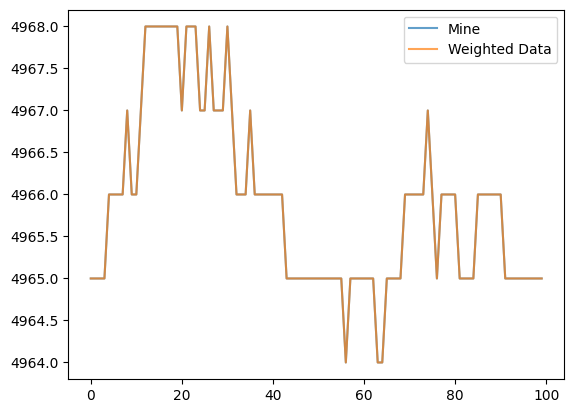

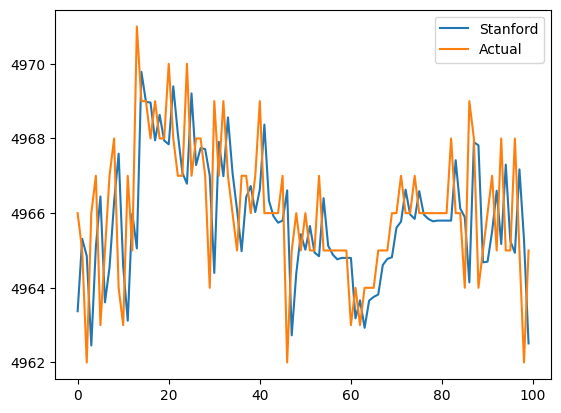

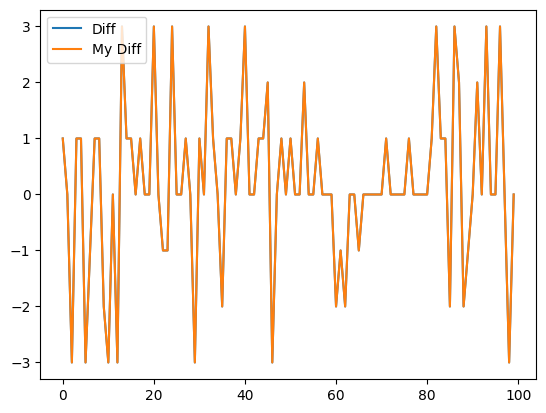

In [128]:
stanford_predictions = []
stanford_coef      = [-0.01869561, 0.0455032, 0.16316049, 0.8090892]
stanford_intercept = 4.481696494462085

my_predictions = []
my_coef        = [0.8090892, 0.16316049]
my_intercept   = 2.112107983502075

# for i in range(0, 4):
    
forecast_starfruit = Forecast(
        ar_coeffs=[0.30360476, 0.35316679, -0.67114275, 0.20554640],
        ma_coeffs=[-0.60509782, -0.31278503, 0.80433990, -0.42750443],
        drift=0,
        forecast_return=True
    )

for i in range(0, 4):
    weighted_price = int(weighted_data[i])
    forecast_starfruit.update(weighted_price)
    forecast_starfruit.forecast(weighted_price)

for i in range(4, len(data)):
    price = int(data[i - 1])
    weighted_price = int(weighted_data[i])
    
    stanford_predictions.append(np.dot(stanford_coef, data[i - 4:i]) + stanford_intercept)
    
    forecast_starfruit.update(weighted_price)
    my_predictions.append(forecast_starfruit.forecast(weighted_price))
    
bid_ask_spread = raw[products[1]]['ask_price_1'] - raw[products[1]]['bid_price_1']
actual = data[4:]
weighted_actual = weighted_data[4:]

stanford_mse = mean_squared_error(actual, stanford_predictions)
my_mse = mean_squared_error(weighted_actual, my_predictions)

resid = np.array(actual) - np.array(my_predictions)

print("Stanford MSE:", stanford_mse)
print("My MSE:", my_mse)
    
n = 1560
l = 100
# plt.plot(stanford_predictions[n:n+l], label='Stanford')
plt.plot(my_predictions[n:n+l], label='Mine', alpha=0.7)
# plt.plot(actual[n:n+l], label='Actual')
plt.plot(weighted_actual[n:n+l], label='Weighted Data', alpha=0.7)
# plt.plot(data_series[n:n+l])

plt.legend()
plt.show()
plt.plot(stanford_predictions[n:n+l], label='Stanford')
plt.plot(actual[n:n+l], label='Actual')
plt.legend()
plt.show()

plt.plot(actual[n:n+l] - weighted_actual[n:n+l], label='Diff')
plt.plot(actual[n:n+l] - my_predictions[n:n+l], label='My Diff')
plt.legend()
plt.show()

(array([ 7.,  6.,  6.,  0., 44., 24.,  4.,  9.]),
 array([-3.  , -2.25, -1.5 , -0.75,  0.  ,  0.75,  1.5 ,  2.25,  3.  ]),
 <BarContainer object of 8 artists>)

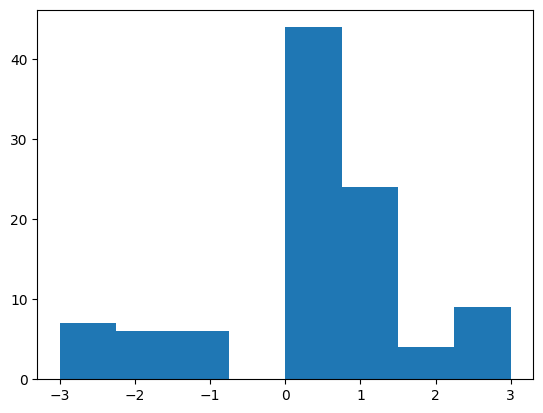

In [129]:
diff = actual[n:n+l] - my_predictions[n:n+l]
plt.hist(diff, bins=8)

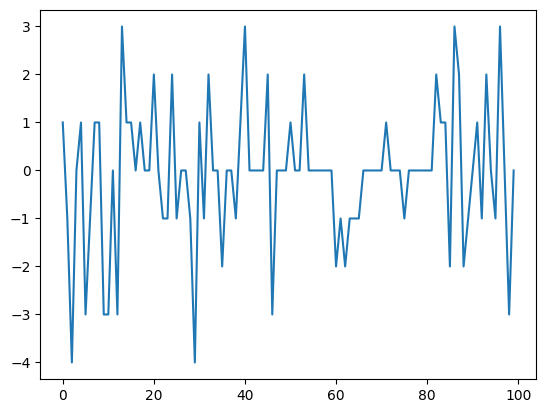

In [127]:
plt.plot(actual[n:n+l] - my_predictions[n:n+l])